# Phase and Frequency Conventions for the NIfTI-MRS Standard

In [30]:
%load_ext autoreload
%autoreload 2
from mapvbvd import mapVBVD
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


## The Problem

Magnetic resonance spectroscopic data is characterized by signal peaks appearing at specific relative frequencies. The direction of the relative shift can be changed by a simple conjugation of the time-domain representation of the data. Given the complex and varied RF hardware, reconstruction, and post-processing applied to MRS data there is no guarantee of the quadrature relationship of the two time-domain channels of data (represented as real and imaginary signal components) in 'raw' spectroscopic data.

## An illustration of the problem
Three similar datasets read from three different vendor's 'raw' formats.
We take the data from the PRESS scans of the 'Big GABA' study, downloading a set of Philips, GE, and Siemens data.

For details on the Big GABA study see:  
- Mikkelsen M et al. Big GABA: Edited MR spectroscopy at 24 research sites. NeuroImage 2017;159:32–45. doi: 10.1016/j.neuroimage.2017.07.021  
- Mikkelsen M et al. Big GABA II: Water-referenced edited MR spectroscopy at 25 research sites. NeuroImage 2019;191:537–548. doi: 10.1016/j.neuroimage.2019.02.059  
- Povazan M et al. Comparison of multivendor single-voxel MR spectroscopy data acquired in healthy brain at 26 sites. Radiology 2020;295:171–180. doi: 10.1148/radiol.2020191037  


In [123]:
%%capture
%sx mkdir convention_data
%sx curl "https://www.nitrc.org/frs/download.php/11686/G6_P.zip//?i_agree=1&download_now=1" --output convention_data/G6_P.zip
%sx unzip convention_data/G6_P.zip -d convention_data

%sx curl "https://www.nitrc.org/frs/download.php/11693/P6_P.zip//?i_agree=1&download_now=1" --output convention_data/P6_P.zip
%sx unzip convention_data/P6_P.zip -d convention_data

%sx curl "https://www.nitrc.org/frs/download.php/11699/S5_P.zip//?i_agree=1&download_now=1" --output convention_data/S5_P.zip
%sx unzip convention_data/S5_P.zip -d convention_data

### Load and prepare GE data using spec2nii tools

In [110]:
from spec2nii.GE.ge_pfile import Pfile

mapper = Pfile('convention_data/G6_P/S01/S01_PRESS_35.7')
ge_press_data = mapper.map.raw_suppressed

# Apply basic processing (averaging and SVD coil combination)
ge_press_data = ge_press_data.copy().squeeze()
ge_press_data = np.mean(ge_press_data,axis=0)
u,s,v = np.linalg.svd(ge_press_data.T,full_matrices=False)
ge_press_data = u[:,0]*s[0]
ge_press_data /= np.max(np.abs(ge_press_data))

### Load and prepare Philips data using spec2nii tools

In [112]:
from spec2nii.philips import read_spar, read_sdat

spar_params = read_spar('convention_data/P6_P/S01/S01_PRESS_35_act.SPAR')
ph_data = read_sdat('convention_data/P6_P/S01/S01_PRESS_35_act.SDAT',
                    spar_params['samples'],
                    spar_params['rows'])
ph_data /= np.max(np.abs(ph_data))

### Load and prepare Siemens data using spec2nii tools (pymapvbvd)

In [129]:
supressed_file = Path('convention_data/S5_P/S01/S01_PRESS_35.dat')
suppressed_raw = mapVBVD(supressed_file,quiet=True)
suppressed_raw.image.removeOS=True
siemens_data = suppressed_raw.image.unsorted()

# Apply basic processing (averaging and SVD coil combination)
siemens_data = np.mean(siemens_data,axis=-1)
u,s,v = np.linalg.svd(siemens_data,full_matrices=False)
siemens_data = u[:,0]*s[0]
siemens_data /= np.max(np.abs(siemens_data))

# Extract some header value for use further down
dwelltime = suppressed_raw['hdr']['MeasYaps'][('sRXSPEC','alDwellTime','0')]/1E9 # For nifti pixel dim
transmitter_frequency_mhz = suppressed_raw['hdr']['MeasYaps'][('sTXSPEC', 'asNucleusInfo', '0', 'lFrequency')]/1E6
spectral_width_hz = 1/(suppressed_raw['hdr']['MeasYaps'][('sRXSPEC','alDwellTime','0')]/1E9)

read data:   0%|          | 0/64 [00:00<?, ?it/s]

### Plot this data

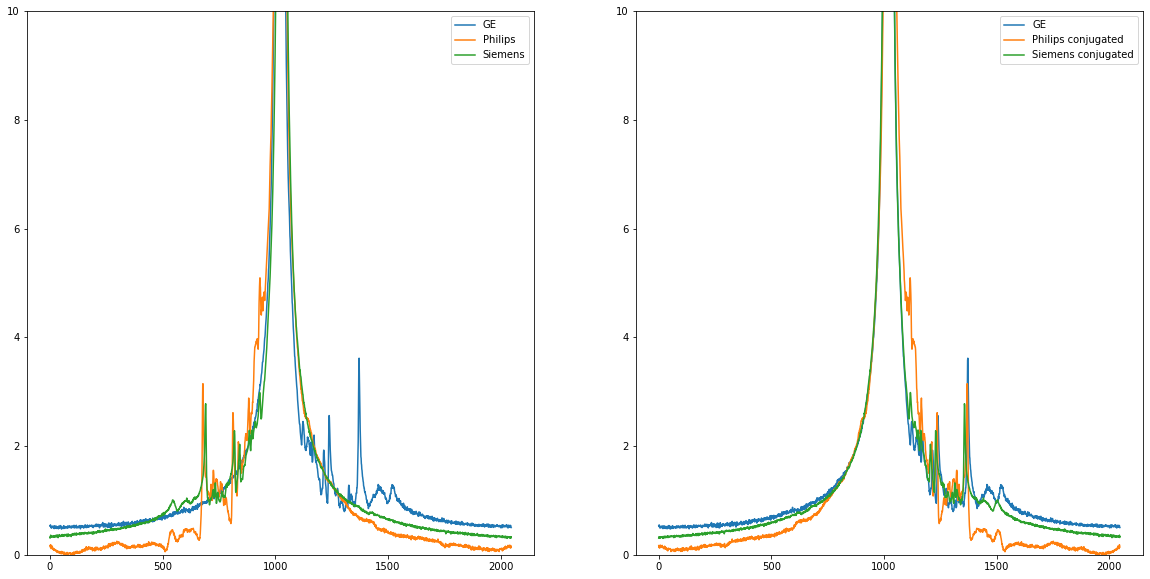

In [138]:
def spec_fft(x):
    return np.fft.fftshift(np.fft.fft(x,axis=0),axes=0)

fig,(ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.plot(np.abs(spec_fft(ge_press_data)), label='GE')
ax1.plot(np.abs(spec_fft(ph_data)), label='Philips')
ax1.plot(np.abs(spec_fft(siemens_data)), label='Siemens')
ax1.set_ylim([0, 10])
ax1.legend()

ax2.plot(np.abs(spec_fft(ge_press_data)), label='GE')
ax2.plot(np.abs(spec_fft(ph_data.conj())), label='Philips conjugated')
ax2.plot(np.abs(spec_fft(siemens_data.conj())), label='Siemens conjugated')
ax2.set_ylim([0, 10])
ax2.legend()

plt.show()

The frequency convention is different between the three vendors. We have to conjugate Philips and Siemens data to match GE, or vice versa.

This becomes a significant problem if we need to apply operations to specific parts of the spectrum, or fit the data using basis spectra (which also suffer from this issue).

We therefore define a convention in NIfTI-MRS which aims to avoid issues further along in processing and analysis pipelines.

### What convention, and how to view the data

In NIfTI-MRS we follow the convention of Levitt (The Signs of Frequencies and Phases in NMR. Journal of Magnetic Resonance 1997;126:164–182 doi: [10.1006/jmre.1997.1161](https://doi.org/10.1006/jmre.1997.1161)). In this convention the absolute frequency scale should increase from left to right, noting that $$\omega=-\gamma B_0.$$

This means for nuclei with a gyromagnetic ratio > 0 this corresponds to resonances from nuclei with less shielding (more deshielding), which therefore experiencing a higher magnetic field, appearing on the left. I.e. they have more negative (higher magnitude) Larmor frequencies.

It is worth stating that the reasons behind this convention are subtle, complex, and mostly motivated by a desire for consistent signs in the relevant Hamiltonian. The interested reader is referred to Levitt's paper, which is both easy to read and compelling.

#### How this is visualised in literature
In the literature spectra are often plotted with a different frequency scale showing more positive relative frequencies on the left. This preserves the orientation of the spectrum but corresponds to a scale equal to  $|\omega|-|\omega_{\textrm{ref}}|$. 

#### A note on FFT conventions
To perform the conversion from time domain to frequency domain we use the numpy FFT implementation. From the [numpy fft documentation](https://numpy.org/doc/stable/reference/routines.fft.html#implementation-details) the discrete Fourier Transform (DFT) is defined as  

$$A_k = \sum_{m=0}^{n-1} a_m exp\Bigl\{-2\pi i \frac{mk}{n}\Bigr\} .$$

This matches Eqn [81] of Levitt . An FFT shift is required as the sum is defined from 0 to n-1. This definition also matches that used in [MATLAB](https://uk.mathworks.com/help/matlab/ref/fft.html).

### How to visualise the different frequency scales
We now will apply this convention to a high quality 7T SVS 1H-MRS acquisition. The data was collected with the spectrometer reference frequency aligned to water. Oversampling has not been removed so limited receiver bandwidth is apparent in these plots.

Here, we will plot the spectrum on:  
1. An absolute frequency scale. I.e. the Larmor frequency is approximately -300 MHz.
2. A typical display magnitude relative frequency scale corresponding to $|\omega|-|\omega_{\textrm{ref}}|$. *Requires a deliberate axes inversion for display.*
3. A chemical shift scale referenced to TMS. *Requires a deliberate axes inversion for display.*

In [133]:
%%capture
%sx curl "https://git.fmrib.ox.ac.uk/fsl/fsl_mrs/-/raw/master/example_usage/example_data/meas_MID310_STEAM_metab_FID115673.dat" --output convention_data/7t_svs.dat

In [136]:
supressed_file = Path('convention_data/7t_svs.dat')
suppressed_raw = mapVBVD(supressed_file,quiet=True)
suppressed_raw.image.removeOS=False
siemens_7tdata = suppressed_raw.image.unsorted()
siemens_7tdata.shape
# Apply basic processing (averaging and SVD coil combination)
siemens_7tdata = np.mean(siemens_7tdata,axis=-1)
u,s,v = np.linalg.svd(siemens_7tdata,full_matrices=False)
siemens_7tdata = u[:,0]*s[0]

# Siemens twix data appears to need a conjugate to achieve the right convention
siemens_7tdata = siemens_7tdata.conj()

# Extract some header value for use further down
dwelltime = suppressed_raw['hdr']['MeasYaps'][('sRXSPEC','alDwellTime','0')]/1E9
transmitter_frequency_mhz = suppressed_raw['hdr']['MeasYaps'][('sTXSPEC', 'asNucleusInfo', '0', 'lFrequency')]/1E6
spectral_width_hz = 1/(suppressed_raw['hdr']['MeasYaps'][('sRXSPEC','alDwellTime','0')]/1E9)

read data:   0%|          | 0/64 [00:00<?, ?it/s]

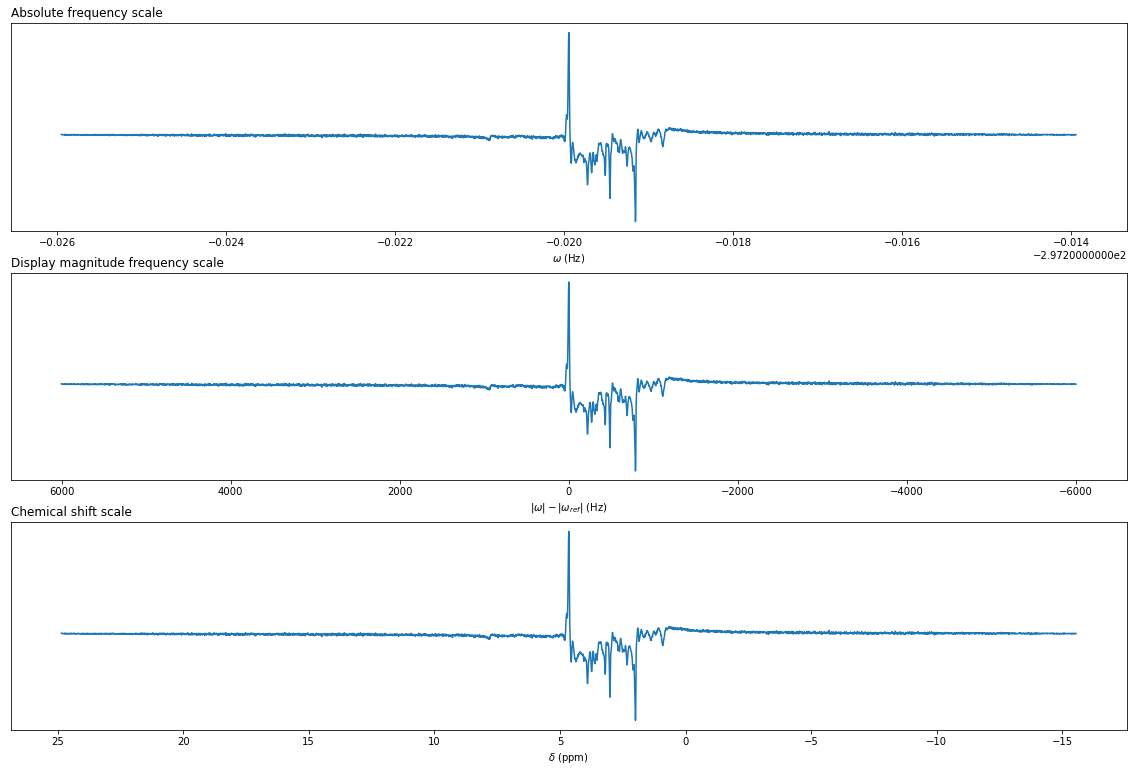

In [139]:
# Make absolute frequency scale (remember the -ve sign in omega=-gamma.B0)
npoints = siemens_7tdata.size
frequency_axis = np.linspace(-spectral_width_hz/2,spectral_width_hz/2,npoints) 
abs_freq_axis = -transmitter_frequency_mhz + frequency_axis/1E6
# Display frequency axis
frequency_axis *= -1
# Chemical shift axis (shifted to TMS)
c_shift_axis = 4.65+ frequency_axis/transmitter_frequency_mhz

#Display
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,13))
ax1.plot(abs_freq_axis,np.real(spec_fft(siemens_7tdata)))
ax1.set_yticks([])
ax1.set_xlabel('$\omega$ (Hz)')
ax1.set_title('Absolute frequency scale',loc='left')

ax2.plot(frequency_axis,np.real(spec_fft(siemens_7tdata)))
ax2.set_yticks([])
ax2.invert_xaxis()
ax2.set_xlabel('$|\omega|-|\omega_{ref}|$ (Hz)')
ax2.set_title('Display magnitude frequency scale',loc='left')

ax3.plot(c_shift_axis,np.real(spec_fft(siemens_7tdata)))
ax3.set_yticks([])
ax3.invert_xaxis()
ax3.set_xlabel('$\delta$ (ppm)')
ax3.set_title('Chemical shift scale',loc='left')

plt.show()

### Working in the time domain - "handedness" of data

The convention can also be checked in the time domain representation of the data. In fact the DICOM standard also has a convention and defines it in the time domain view. Section [C.8.14.4.1](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.8.14.4.html) of the DICOM standard tries to make this definition of in what sense the magnetization should be viewed and therefore the frequency axis direction.

    #### C.8.14.4.1 Spectroscopy Data

    The spectral data points are ordered in sequence of increasing time in the case that the Signal Domain Columns (0028,9003) or Signal Domain Rows (0028,9235) Attributes contain the value TIME.  

    The apparent rotation of magnetization in a quadrature representation shall be counterclockwise (from the (positive) real part to the (positive) imaginary part) for positive relative frequencies.  

    ##### Note
        When Complex time data points are transformed by a straightforward Fourier transformation to complex spectral data points, these are ordered from low frequency to high frequency.
        
However this definition doesn't define well what is meant by a quadrature representation (beyond detecting real and imaginary parts) nor (and more importantly) does it define what is meant by "positive relative frequencies". We assume that if the FID is viewed from above, its handedness should reveal itself:

Define a right-handed coordinate frame (right panel):  
![image.png](specification_images/right-handed_half.png)

Define the x-axis to be the real component, y the imaginary component and z as time.  
Display as the figure above and looking down the time axis.

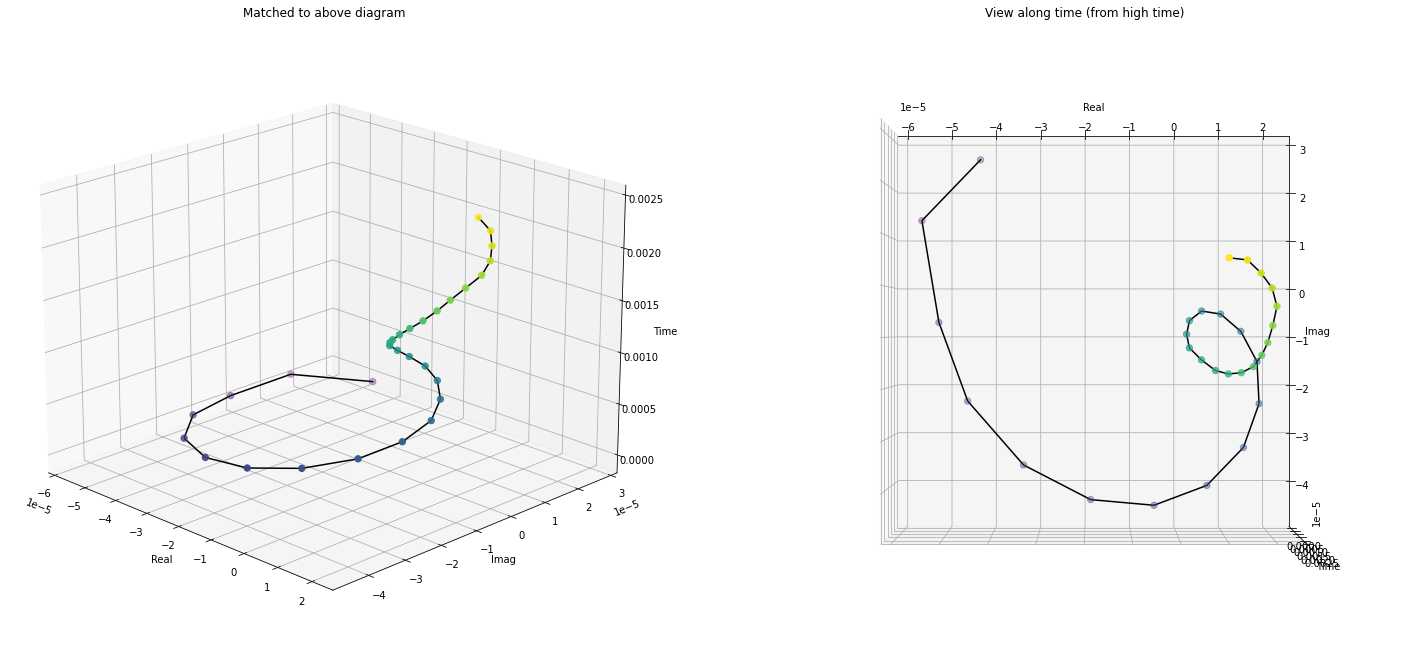

In [143]:
time_axis = dwelltime*np.arange(0,siemens_7tdata.size)
fig = plt.figure(figsize=(25,12.5))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot3D(np.real(siemens_7tdata[:30]),np.imag(siemens_7tdata[:30]),time_axis[:30],'k')
ax.scatter3D(np.real(siemens_7tdata[:30]),np.imag(siemens_7tdata[:30]),time_axis[:30], c=time_axis[:30],s=40);
ax.view_init(20, -45)
ax.set_zlabel('Time')
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_title('Matched to above diagram')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot3D(np.real(siemens_7tdata[:30]),np.imag(siemens_7tdata[:30]),time_axis[:30],'k')
ax.scatter3D(np.real(siemens_7tdata[:30]),np.imag(siemens_7tdata[:30]),time_axis[:30], c=time_axis[:30],s=40);
ax.view_init(90, -90)
ax.set_zlabel('Time')
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_title('View along time (from high time)')
plt.show()

From these plots we can see that for nuclei with a positive gyromagnetic ratio $(\gamma>0)$ positive frequencies (on the absolute scale, equivalent to lower chemical shifts) are counter-clockwise (positive).
![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Right-hand_grip_rule.svg/220px-Right-hand_grip_rule.svg.png)

For nuclei with a negative gyromagnetic ratio $(\gamma<0)$ then this same relationship should hold if the time domain data is conjugated before storage.


### Specification wording
- The time-domain spectral data points are ordered in sequence of increasing time.
- In a right-handed coordinate system (x corresponding to real values, y imaginary values, and z time):  
    - data arising from nuclei with a positive gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute frequency scale and relative to the spectrometer reference frequency) appear to have a positive (counter-clockwise) rotation.
    - data arising from nuclei with a negative gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute frequency scale and relative to the spectrometer reference frequency) appear to have a negative (clockwise) rotation.

In [144]:
# Cleanup
%sx rm -rf convention_data/

[]